In [1]:
import time
from os.path import dirname, join, realpath
from datetime import timedelta, datetime
import pandas as pd
import requests
import matplotlib
matplotlib.use('Agg')
from matplotlib.pyplot import *

import settings

# Show Plots in the Notebook
%matplotlib inline

In [2]:
APP_PATH = '/home/tabb99/solar-summary'
url = 'https://api.enphaseenergy.com/api/v2/systems/{}/'.format(settings.SYSTEM_ID)

# Files that track last record loaded and all records.
FN_LAST_TS = join(APP_PATH, 'last_ts')
FN_RECORDS = join(APP_PATH, 'records.csv')

In [3]:
if settings.COLLECT:

    payload_base = {
        'key': settings.API_KEY,
        'user_id': settings.USER_ID,
    }

    try:
        start_at = int(open(FN_LAST_TS).read())
    except:
        start_at = requests.get(url + 'summary', params=payload_base).json()['operational_at']

    payload = payload_base.copy()

    for i in range(9):
        time.sleep(2)
        print(start_at)
        payload['start_at'] =  start_at
        res = requests.get(url + 'stats', params=payload).json()
        if 'intervals' not in res:
            break
        recs = list(map(lambda r: (r['end_at'], r['devices_reporting'], r['powr']), res['intervals']))
        if len(recs):
            with open(FN_RECORDS, 'a') as fout:
                for rec in recs:
                    fout.write('{},{},{}\n'.format(*rec))
            start_at = recs[-1][0]
        else:
            # sometimes there will be a 24 hour period without any reports, so advance
            # the starting time a day and try again.  Only do this if it will not advance
            # beyond the current time.
            if time.time() > start_at + 24*3600:
                start_at += 24*3600

    open(FN_LAST_TS, 'w').write(str(start_at))


1629660000


In [4]:
MONTH_NAMES = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

def get_data(use_dst=True):
    """ Read the data, delete device count column.
    Rembmer that the timestamps mark the end of the interval
    Make a Date/Time field, Alaska Time, and use it for the 
    index.  Fill out missing 5 minute intervals with 0s.
    If 'use_dst' is True, account for Daylight Savings Time.
    Drop the 'usecols' parameter to get the 'device_count' column
    as well.
    """
    dfd = pd.read_csv(FN_RECORDS, usecols=['ts', 'power'])
    dfd['dts'] = pd.to_datetime(dfd.ts, unit='s')
    dfd.drop(['ts'], axis=1, inplace=True)
    if not use_dst:
        akst_adj = timedelta(hours=9)
        dfd['dts'] = dfd.dts - akst_adj
    dfd.set_index('dts', inplace=True)
    dfd = dfd[~dfd.index.duplicated(keep='last')]
    dfd = dfd.asfreq('5T', fill_value=0.0)
    if use_dst:
        dfd.index = dfd.index.tz_localize('UTC').tz_convert('US/Alaska').tz_localize(None)

    return dfd

def save_plot(file_name):
    """Saves the current Matplotlib figure to the file 'file_name'
    in the PNG format (with a .png extension) in the 'images' subdirectory.  
    Prior to saving, executes the tight_layout() command to reduce 
    whitesapce around the plot area of the figure.
    """
    tight_layout()
    savefig(join(APP_PATH, 'images/{}.png'.format(file_name)))

# 'style' the plot like fivethirtyeight.com website
style.use('bmh')

rcParams['figure.figsize']= (10, 7)   # set Chart Size
rcParams['font.size'] = 14            # set Font size in Chart


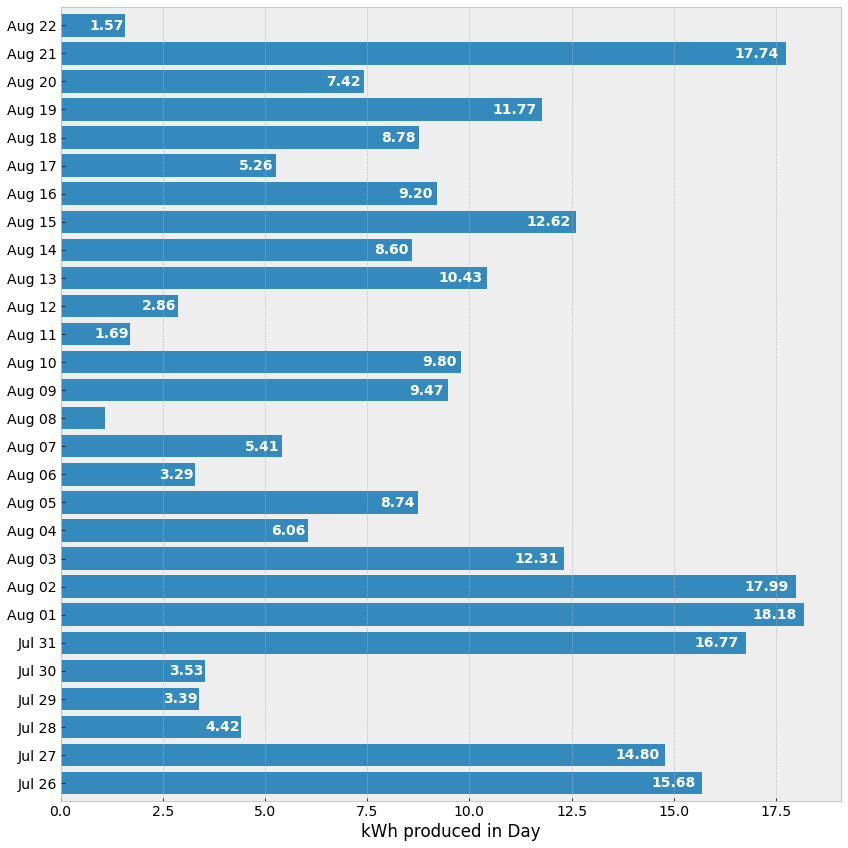

In [7]:
    df = get_data(use_dst=True)
    # Save it to a pickle file for download
    df.to_pickle(join(APP_PATH, 'df_solar.pkl'))

    # kWh bar graph for last 4 weeks production
    dfd = df.resample('1D').sum()/12000.
    dfd.columns=['kWh']
    dfdt = dfd.tail(28)
    dfdt.plot.barh(legend=False, width=0.8, figsize=(12, 12))
    grid(axis='y')
    yticklabels = [d.strftime('%b %d') for d in dfdt.index]
    yticks(range(len(dfdt)), yticklabels)
    gca().get_yaxis().get_label().set_visible(False)
    xlabel('kWh produced in Day')
    for i in range(len(dfdt)):
        kWh = dfdt.iloc[i].kWh 
        if kWh > dfdt.kWh.max() * 0.07:
            text(kWh*.99, i-.15, 
                '{:.2f}'.format(kWh), 
                horizontalalignment='right',
                weight='bold',
                color='white')
    save_plot('last_days')


In [14]:
cur_day, prev_day, dfdt.kWh.idxmax()


'2021-08-22 00:00:00'

In [50]:
    # Plot last few days in data set.

    def day_to_lbl(d):
        return str(d)[:10]

    clf()
    cur_day = dfdt.index[-1]
    prev_day = dfdt.index[-2]
    max_day = dfdt.kWh.idxmax()
    min_day = dfdt[:-1].kWh.idxmin()

    max_done = False
    min_done = False
    if cur_day == max_day:
        cur_day_lbl = f'{day_to_lbl(cur_day)} max'
        max_done = True
    else:
        cur_day_lbl = day_to_lbl(cur_day)

    if prev_day == max_day:
        prev_day_lbl = f'{day_to_lbl(prev_day)} max'
        max_done = True
    elif prev_day == min_day:
        prev_day_lbl = f'{day_to_lbl(prev_day)} min'
        min_done = True
    else:
        prev_day_lbl = day_to_lbl(prev_day)
        
    plot_days = [
        (cur_day, cur_day_lbl),
        (prev_day, prev_day_lbl)
    ]
    if not max_done:
        plot_days.append(
            (max_day, f'{day_to_lbl(max_day)} max')
        )
    if not min_done:
        plot_days.append(
            (min_day, f'{day_to_lbl(min_day)} min')
    )

    figure(figsize=(10, 7))
    for dt, lbl in plot_days:
        df_1day = df.loc[str(dt) : str(dt + pd.Timedelta('86399S'))]   # through last second of day
        xvals = [t.hour + t.minute/60 for t in df_1day.index.time]
        if dt==cur_day:
            plot(xvals, df_1day.power, linewidth=3, label=lbl)
        elif dt==prev_day:
            plot(xvals, df_1day.power, linewidth=1.2, label=lbl)
        else:
            plot(xvals, df_1day.power, linewidth=1.2, linestyle='--', label=lbl)        
            
    xticks(range(0, 24, 2)) 
    legend()
    ylabel('Power Produced Today, Watts')
    xlabel('Hour of Day')
    save_plot('last_day')

[(Timestamp('2021-08-22 00:00:00', freq='D'), '2021-08-22'),
 (Timestamp('2021-08-21 00:00:00', freq='D'), '2021-08-21'),
 (Timestamp('2021-08-01 00:00:00', freq='D'), '2021-08-01 max'),
 (Timestamp('2021-08-08 00:00:00', freq='D'), '2021-08-08 min')]

<Figure size 720x504 with 0 Axes>

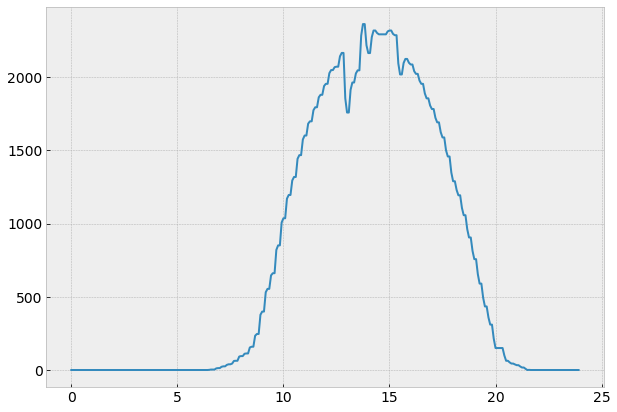

In [78]:
xvals = [t.hour + t.minute/60 for t in df_1day.index.time]
plot(xvals, df_1day.power)

TypeError: float() argument must be a string or a number, not 'datetime.time'

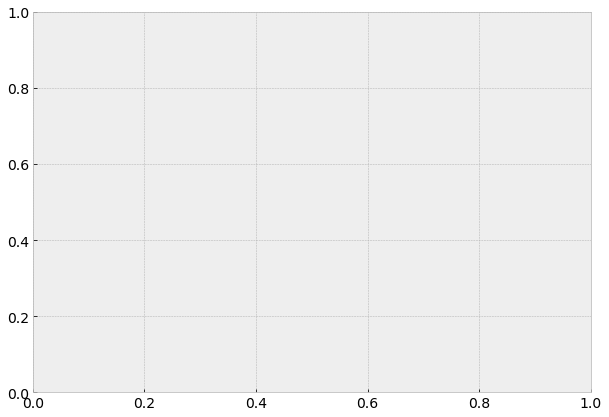

In [66]:
prevd = prev_day.to_datetime64()
df_1day = df.loc[str(prevd) : str(prevd + pd.Timedelta('86399S'))]
plot(df_1day.index.time, df_1day.power)

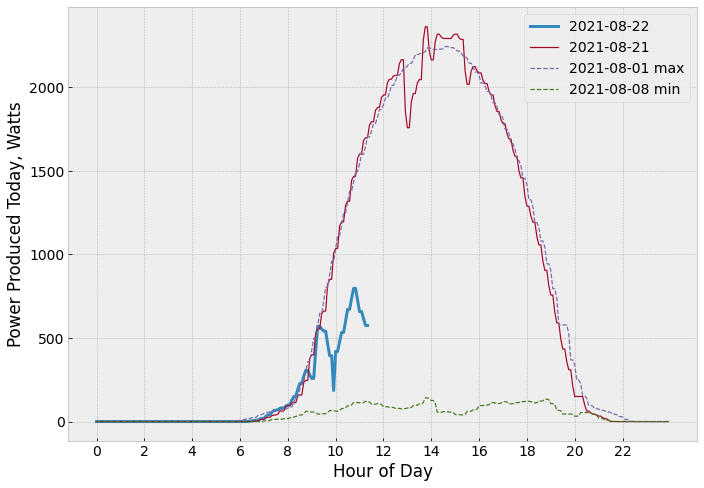

In [82]:
    
    figure(figsize=(10, 7))
    for dt, lbl in plot_days:
        df_1day = df.loc[str(dt) : str(dt + pd.Timedelta('86399S'))]   # through last second of day
        xvals = [t.hour + t.minute/60 for t in df_1day.index.time]
        if dt==cur_day:
            plot(xvals, df_1day.power, linewidth=3, label=lbl)
        elif dt==prev_day:
            plot(xvals, df_1day.power, linewidth=1.2, label=lbl)
        else:
            plot(xvals, df_1day.power, linewidth=1.2, linestyle='--', label=lbl)        
            
    xticks(range(0, 24, 2)) 
    legend()
    ylabel('Power Produced Today, Watts')
    xlabel('Hour of Day')
    save_plot('last_day')